# Extracting image search queries from text

Mems that get sent to Proxi should have an image associated with them. Human players should have an easy enough time finding images that represent, but when we have nothing but a chunk of text to go on, this is more difficult. What words are important? Do important words build clear, unambiguous queries?

## Interacting with image search APIs

First things first: I need a way to search the internet for images. I'll be using a combination of the Noun Project API, along with the Bing Image Search API. I considered using Google's Custom Image Search, but the daily limits (100 searches/day) were a little low for my use.

Here are some quick functions to format the GET requests for Bing and the Noun Project.

In [142]:
import os
import json
import requests
from requests_oauthlib import OAuth1


def get_secret(service):
    """Access local store to load secrets."""
    local = os.getcwd()
    root = os.path.sep.join(local.split(os.path.sep)[:3])
    secret_pth = os.path.join(root, '.ssh', '{}.json'.format(service))
    return secret_pth


def load_secret(service):
    """Load secrets from a local store.

    Args:
        server: str defining server

    Returns:
        dict: storing key: value secrets
    """
    pth = get_secret(service)
    secret = json.load(open(pth))
    return secret

BING_API_KEY = load_secret('bing')
NP_API_KEY, NP_API_SECRET = load_secret('noun_project')

def search_bing_for_image(query):
    """
    Perform a Bing image search.

    Args:
        query: Image search query

    Returns:
        results: List of urls from results
    """
    search_params = {'q': query,
                     'mkt': 'en-us',
                     'safeSearch': 'strict'}
    auth = {'Ocp-Apim-Subscription-Key': BING_API_KEY}
    url = 'https://api.cognitive.microsoft.com/bing/v5.0/images/search'
    r = requests.get(url, params=search_params, headers=auth)
    results = r.json()['value']
    urls = [result['contentUrl'] for result in results]
    return urls

def search_np_for_image(query):
    """
    Perform a Noun Project image search.

    Args:
        query: Image search query

    Returns:
        results: List of image result JSON dicts
    """
    auth = OAuth1(NP_API_KEY, NP_API_SECRET)
    endpoint = 'http://api.thenounproject.com/icons/{}'.format(query)
    params = {'limit_to_public_domain': 1,
              'limit': 5}
    response = requests.get(endpoint, params=params, auth=auth)
    urls = [icon['preview_url'] for icon in response.json()['icons']]
    return urls

In [35]:
print(search_np_for_image('magic')[:3])

['https://d30y9cdsu7xlg0.cloudfront.net/noun-svg/8645.svg?Expires=1501639879&Signature=Rj~S3KxwCxFk--IU58qC~zGsy0AFsmz~aEDv7pkQH4pfli6K8i08j4dcNwDjNO3nuKeDtNTFq8K-C1pXcWXIljJREcNPjdakPwQOzqBuSeVolqFifwuh1DMKQzMtC5C~VrAb7dw-4gUWEsH6NJcGLGCY-mxt0cj4XVQf8kG3XGM_&Key-Pair-Id=APKAI5ZVHAXN65CHVU2Q', 'https://d30y9cdsu7xlg0.cloudfront.net/noun-svg/3217.svg?Expires=1501639879&Signature=MTSf1qPbtDaKA0~ab-HWZyq7XiNE4oi7pvy4namTw3-OIE5jU33wuq0beT522kgMes01auH3n9bVrLnUoDC2VzyTjVhrthLJxwXwZbyxi6HcllFzN1BzhfGUuqHlwTYS0sGktl2xebynD2m-f~LLBpasAOctAuSj0I8XJhhiqLA_&Key-Pair-Id=APKAI5ZVHAXN65CHVU2Q', 'https://d30y9cdsu7xlg0.cloudfront.net/noun-svg/9878.svg?Expires=1501639879&Signature=SwTXoTWp50abQblJBIv8f~ziPICqtGQIgPbbv8onarfaRiZ9wgE0~BAquxUJCXP3C9ZEHPFjIX1AqNUW6z4iVgjrced7ubtrSq2hKeDmWvsLHb8-H~kRa~V22ylNtgq9oKvfTy9c2vy~WbI7kglmB6v2wj~vm59VTn-gknMvSao_&Key-Pair-Id=APKAI5ZVHAXN65CHVU2Q']


In [36]:
print(search_bing_for_image('magic')[:3])

['https://www.bing.com/cr?IG=893B15BD36B347CFA2E37A209B2C2407&CID=2A80ECC40B1A6A8431DEE6160A456BA7&rd=1&h=s8RALD9BDBMuZXoQUMU3oI1RUfDXCCYb36-vrJUL5eg&v=1&r=https%3a%2f%2fcdn1.epicgames.com%2fue%2fitem%2fKYmagicFX05_Screenshot_03-1920x1080-900ec2990047d3efab8eb343bcd4761e.png&p=DevEx,5008.1', 'http://www.bing.com/cr?IG=893B15BD36B347CFA2E37A209B2C2407&CID=2A80ECC40B1A6A8431DEE6160A456BA7&rd=1&h=BlawP31r5U0AFQXxQg9X0ArVzE4daaCQS_8hDw8vU3M&v=1&r=http%3a%2f%2fupload.wikimedia.org%2fwikipedia%2fen%2f8%2f83%2fLife_is_magic.jpg&p=DevEx,5014.1', 'https://www.bing.com/cr?IG=893B15BD36B347CFA2E37A209B2C2407&CID=2A80ECC40B1A6A8431DEE6160A456BA7&rd=1&h=iDcKG5u98YbRr96D8TpJ52bhOcMp-YQpsA8WJxb8CDI&v=1&r=https%3a%2f%2fdefeatingthedragons.files.wordpress.com%2f2014%2f01%2fmagic-book.jpg&p=DevEx,5020.1']


For quick prototyping, I wrote another function to display an image from its URL.

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
import urllib
%matplotlib inline

def view_urls(urls):
    """Display the images found at the provided urls"""
    for i, url in enumerate(urls):
        resp = requests.get(url)
        dat = urllib.request.urlopen(resp.url)
        img = Image.open(dat)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

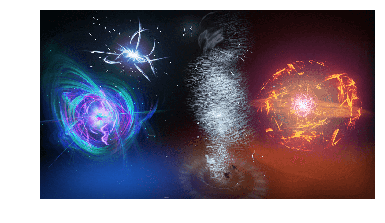

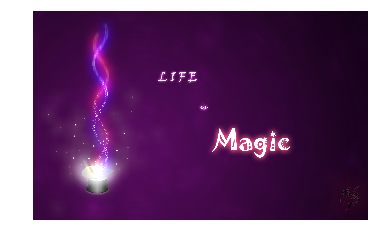

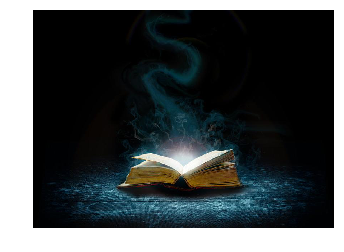

In [57]:
view_urls(search_bing_for_image('magic')[:3])

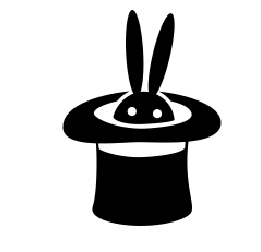

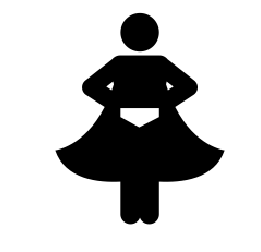

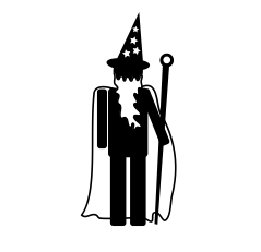

In [61]:
view_urls(search_np_for_image('magic')[:3])

## Finding important words

My teammates and I have done a lot of work these past few weeks extracting the names of people, places, things, activities, and moods from text. This work has been incorporated into a Python package, [Pensieve](https://github.com/CDIPS-AI-2017/pensieve). I'll load up the package and take a look at the words that were extracted from the paragraphs in Harry Potter and the Sorcerer's Stone.

In [1]:
import pensieve

Loading spaCy...


In [2]:
book1 = pensieve.Doc('../../corpus/book1.txt', doc_id=1)

In [9]:
from pprint import pprint
from numpy.random import randint

In [11]:
rand = randint(len(book1.paragraphs))
print(book1.paragraphs[rand].text)
pprint(book1.paragraphs[rand].words)

“Well, I’ve bin doin’ some readin’,” said Hagrid, pulling a large book from under his pillow. “Got this outta the library — Dragon Breeding for Pleasure and Profit — it’s a bit outta date, o’ course, but it’s all in here. Keep the egg in the fire, ’cause their mothers breathe on ’em, see, an’ when it hatches, feed it on a bucket o’ brandy mixed with chicken blood every half hour. An’ see here — how ter recognize diff’rent eggs — what I got there’s a Norwegian Ridge-back. They’re rare, them.”
{'activities': Counter({'get': 1,
                        'mix': 1,
                        'have': 1,
                        'hatch': 1,
                        'breathe': 1}),
 'people': Counter(),
 'places': Counter(),
 'things': Counter({'’em': 2,
                    'bin': 1,
                    'egg': 1,
                    'what': 1,
                    'fire': 1,
                    'Hagrid': 1,
                    'his pillow': 1,
                    'their mothers': 1,
                  

It is nice that the objects and verbs are extracted, but there are too many to just throw into one search query. In order to find the most, let's play around with some features in textacy that can give some sort of importance ordering to the words in the paragraph. Most of these features effectively implement different vertex importance sorting algorithms on a semantic network, so a nice place to start might be at the semantic network itself

In [37]:
import textacy
import networkx as nx

They had to study the night skies through their telescopes every Wednesday at midnight and learn the names of different stars and the movements of the planets. Three times a week they went out to the greenhouses behind the castle to study Herbology, with a dumpy little witch called Professor Sprout, where they learned how to take care of all the strange plants and fungi, and found out what they were used for.


/Users/samdixon/miniconda/envs/cdips/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/samdixon/miniconda/envs/cdips/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


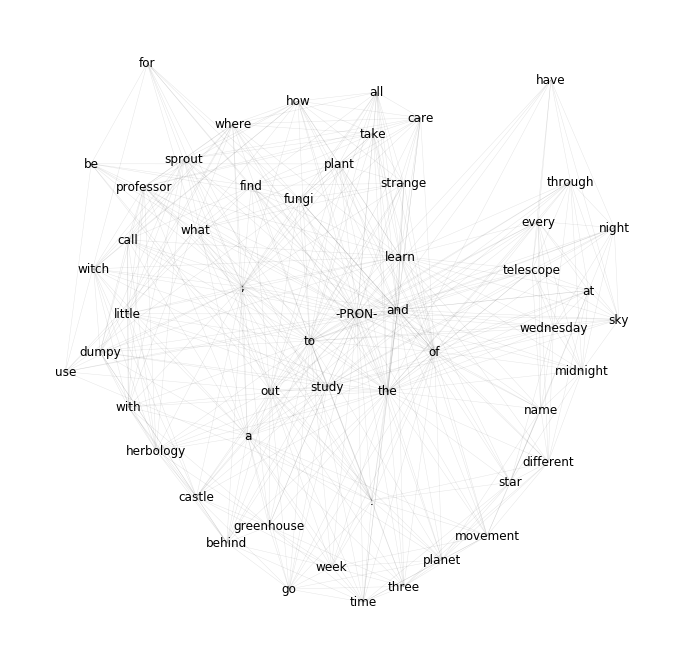

In [74]:
graph = textacy.network.terms_to_semantic_network(book1.paragraphs[400].spacy_doc)
print(book1.paragraphs[400].text)
textacy.viz.draw_semantic_network(graph);

First, we'll look at `textacy.keyterms.textrank`. This implements the [TextRank algorithm](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf), which iteratively computes a score for each vertex in the graph that roughly corresponds to the number of vertices connected to that vertex.

In [75]:
print(book1.paragraphs[400].text)
textacy.keyterms.textrank(book1.paragraphs[400].spacy_doc)

They had to study the night skies through their telescopes every Wednesday at midnight and learn the names of different stars and the movements of the planets. Three times a week they went out to the greenhouses behind the castle to study Herbology, with a dumpy little witch called Professor Sprout, where they learned how to take care of all the strange plants and fungi, and found out what they were used for.


[('plant', 0.04827274469872576),
 ('sky', 0.04827274469872576),
 ('telescope', 0.04534336318665093),
 ('strange', 0.04534336318665093),
 ('wednesday', 0.043714730112683814),
 ('care', 0.043714730112683814),
 ('midnight', 0.04280599889449462),
 ('sprout', 0.04280599889449462),
 ('name', 0.04230208483358708),
 ('professor', 0.04230208483358708)]

This seems to work pretty well! I suppose in this example, I may have chosen "study", but "plant" still makes sense. Let's look at another paragraph to see what happens.

In [80]:
print(book1.paragraphs[654].text)
textacy.keyterms.textrank(book1.paragraphs[654].spacy_doc)

The rest of the team hung back to talk to one another as usual at the end of practice, but Harry headed straight back to the Gryffindor common room, where he found Ron and Hermione playing chess. Chess was the only thing Hermione ever lost at, something Harry and Ron thought was very good for her.


[('ron', 0.11002044374648388),
 ('harry', 0.10806675660113794),
 ('hermione', 0.10210879478328831),
 ('team', 0.08043427061886416),
 ('chess', 0.07746361473180592),
 ('usual', 0.07424581481224891),
 ('end', 0.06905679156597795),
 ('practice', 0.063026486507203),
 ('common', 0.061866830196711846),
 ('room', 0.060386964904953495)]

We may run into trouble when the most important nodes are character names. An image search with the query "ron" or even "ron harry potter" is unlikely to give us good results. More on this later...

What about other algorithms? Let's try [SGRank](http://www.aclweb.org/anthology/S15-1013). This algorithm improves upon TextRank by getting rid of unlikely keyword candidates and performing multiple rankings. It is also capable of outputting multiple word phrases.

In [81]:
print(book1.paragraphs[400].text)
textacy.keyterms.sgrank(book1.paragraphs[400].spacy_doc)

They had to study the night skies through their telescopes every Wednesday at midnight and learn the names of different stars and the movements of the planets. Three times a week they went out to the greenhouses behind the castle to study Herbology, with a dumpy little witch called Professor Sprout, where they learned how to take care of all the strange plants and fungi, and found out what they were used for.


[('dumpy little witch', 0.24589751198272874),
 ('different star', 0.14507606544165436),
 ('night sky', 0.10450120534872356),
 ('professor sprout', 0.0902113089690055),
 ('strange plant', 0.05995872896614336),
 ('herbology', 0.033373074287608925),
 ('week', 0.03216397122424419),
 ('castle', 0.0321176005834551),
 ('greenhouse', 0.030605547678115592),
 ('time', 0.02960159622180038)]

In [83]:
print(book1.paragraphs[654].text)
textacy.keyterms.sgrank(book1.paragraphs[654].spacy_doc)

The rest of the team hung back to talk to one another as usual at the end of practice, but Harry headed straight back to the Gryffindor common room, where he found Ron and Hermione playing chess. Chess was the only thing Hermione ever lost at, something Harry and Ron thought was very good for her.


[('gryffindor common room', 0.22366709420739259),
 ('harry', 0.17069354208353457),
 ('chess', 0.11317870863603838),
 ('ron', 0.1089127097302768),
 ('thing hermione', 0.07677607552923332),
 ('hermione', 0.06877055855743007),
 ('practice', 0.054357521599849065),
 ('end', 0.04559977404077879),
 ('usual', 0.039306233093084696),
 ('team', 0.03781419853714421)]

Now this may end up being a little too specific for our purposes. "gryffindor common room" would be a great result for this image, but "dumpy little witch" is not as good...

[DivRank](http://clair.si.umich.edu/~radev/papers/SIGKDD2010.pdf) attempts to provide a ranking that balances node centrality with node diversity. Let's see how that fares.

In [90]:
print(book1.paragraphs[400].text)
textacy.keyterms.key_terms_from_semantic_network(book1.paragraphs[400].spacy_doc, ranking_algo='divrank')

They had to study the night skies through their telescopes every Wednesday at midnight and learn the names of different stars and the movements of the planets. Three times a week they went out to the greenhouses behind the castle to study Herbology, with a dumpy little witch called Professor Sprout, where they learned how to take care of all the strange plants and fungi, and found out what they were used for.


[('plant', 0.052034409863349694),
 ('sky', 0.05201661460353167),
 ('little', 0.05176247170202021),
 ('professor', 0.045785039013689646),
 ('herbology', 0.045742003661854394),
 ('telescope', 0.04232886359173879),
 ('castle', 0.0423073866950337),
 ('strange', 0.04228885506583182),
 ('sprout', 0.042262846859078405),
 ('name', 0.04170665961969655)]

In [91]:
print(book1.paragraphs[654].text)
textacy.keyterms.key_terms_from_semantic_network(book1.paragraphs[654].spacy_doc, ranking_algo='divrank')

The rest of the team hung back to talk to one another as usual at the end of practice, but Harry headed straight back to the Gryffindor common room, where he found Ron and Hermione playing chess. Chess was the only thing Hermione ever lost at, something Harry and Ron thought was very good for her.


[('team', 4550795553077568.0),
 ('ron', 0.08170990454167519),
 ('harry', 0.05078125),
 ('hermione', 0.05078125),
 ('chess', 0.02734375),
 ('common', 0.0234375),
 ('room', 0.015625),
 ('thing', 0.015625),
 ('end', 0.01171875),
 ('gryffindor', 0.01171875)]

We seem to be getting pretty consistent results between DivRank and TextRank. For simplicity, I'm settling on TextRank.

## Building the queries

### Removing character names
If the most important node in the semantic network is a character's name, we are unlikely to get decent image search results. The quickest way around this is to move down the ranking until we find a term that isn't a named character. Pensieve collects a list of all of the people named in a document, so this is simple to implement.

In [145]:
def build_query(par):
    """
    Use TextRank to find the most important words that aren't character names.
    """
    keyterms = textacy.keyterms.textrank(par.spacy_doc)
    for keyterm, rank in keyterms:
        if keyterm.title() not in par.doc.words['people']:
            return keyterm
    return None

In [146]:
par = book1.paragraphs[randint(len(book1.paragraphs))]
print(par.text)
build_query(par)

Suddenly, Harry felt wide-awake. The whole of Hogwarts was open to him in this cloak. Excitement flooded through him as he stood there in the dark and silence. He could go anywhere in this, anywhere, and Filch would never know.


'silence'

### Deciding which search engine to use

We'll probably get good enough results by trying the Noun Project first and using Bing for everything else.

In [166]:
def submit_query(query):
    """
    Decide which search engine to use based on the part of speech of the query
    """
    doc = textacy.Doc(query, lang='en')
    try:
        urls = search_np_for_image(query)
    except Exception as e:
        urls = search_bing_for_image(query)
    return urls

They had to study the night skies through their telescopes every Wednesday at midnight and learn the names of different stars and the movements of the planets. Three times a week they went out to the greenhouses behind the castle to study Herbology, with a dumpy little witch called Professor Sprout, where they learned how to take care of all the strange plants and fungi, and found out what they were used for.
plant


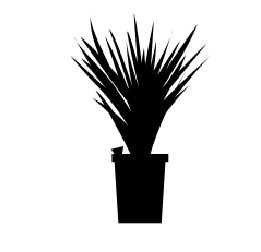

In [173]:
par = book1.paragraphs[400]
print(par.text)
query = build_query(par)
print(query)
urls = submit_query(query)
view_urls(urls[:1])